===== df_cluster (Before Imputation) Info =====
Shape: (13914, 8)

Column Types:
C Government                 float64
C Political parties          float64
C Courts                     float64
C Police                     float64
Importance of democracy      float64
Highest educational level    float64
Scale of incomes             float64
Age                          float64
dtype: object

Missing Values (per column):
C Government                 271
C Political parties          445
C Courts                     418
C Police                     154
Importance of democracy      350
Highest educational level    254
Scale of incomes             771
Age                          140
dtype: int64

Descriptive Statistics (numeric columns):
       C Government  C Political parties      C Courts      C Police  \
count  13643.000000         13469.000000  13496.000000  13760.000000   
mean       2.731364             2.986339      2.303127      2.194186   
std        0.852416             0.706029   

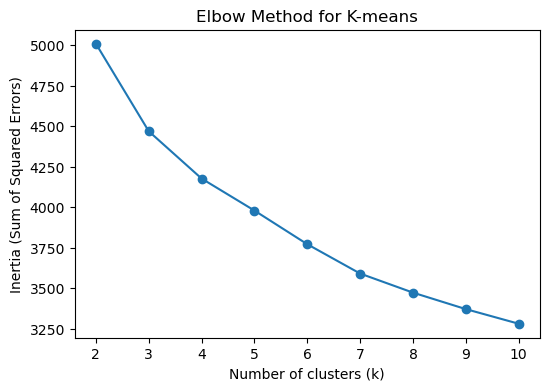

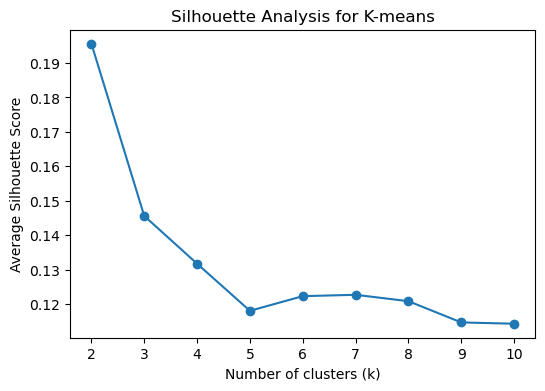

k=2, silhouette=0.196
k=3, silhouette=0.146
k=4, silhouette=0.132
k=5, silhouette=0.118
k=6, silhouette=0.122
k=7, silhouette=0.123
k=8, silhouette=0.121
k=9, silhouette=0.115
k=10, silhouette=0.114

PCA explained variance ratio: [0.34327855 0.14134767]


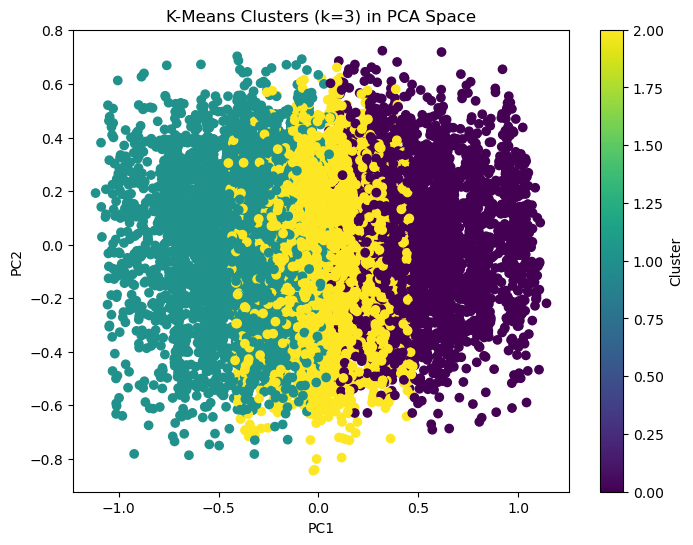

Plots saved to 'kmeans_cluster_plots.pdf'


In [ ]:
import pandas as pd
import numpy as np

# For clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# For dimensionality reduction
from sklearn.decomposition import PCA

# For metrics/analysis
from sklearn.metrics import silhouette_score

# For plotting
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages

##############################################################################
# 1) Helper Functions for Data Diagnostics
##############################################################################
def data_diagnostics(df, name="DataFrame"):
    """
    Prints out useful information about a DataFrame:
    - Shape (rows, columns)
    - Column names and data types
    - Count of missing values
    - Descriptive statistics (numeric only)
    - Sample rows
    """
    print(f"===== {name} Info =====")
    print(f"Shape: {df.shape}")
    
    print("\nColumn Types:")
    print(df.dtypes)
    
    print("\nMissing Values (per column):")
    print(df.isnull().sum())
    
    numeric_cols = df.select_dtypes(include=["int", "float"]).columns
    if len(numeric_cols) > 0:
        print("\nDescriptive Statistics (numeric columns):")
        print(df[numeric_cols].describe())
    else:
        print("\nNo numeric columns to describe.")
    
    print("\nSample Rows:")
    print(df.head())
    print("====================================\n")

def print_unique_values(df, max_print=10):
    """
    Prints unique values for each column in the DataFrame.
    If there are more than `max_print` unique values, 
    it only prints the first `max_print`.
    """
    for col in df.columns:
        unique_vals = df[col].unique()
        print(f"\nColumn: {col}")
        print(f"Number of Unique Values: {len(unique_vals)}")
        if len(unique_vals) <= max_print:
            print("Unique Values:", unique_vals)
        else:
            print("Sample of Unique Values:", unique_vals[:max_print], "...")
    print("====================================\n")

##############################################################################
# 2) Load Data
##############################################################################
wave7_csv = "data/preprocessed/cleaned_wave_7_rq2.csv"
df = pd.read_csv(wave7_csv, low_memory=True)

##############################################################################
# 3) Filter for G8 Countries
##############################################################################
# G8 numeric codes (ISO 3166-1):
# 840 (USA), 124 (Canada), 250 (France), 276 (Germany),
# 380 (Italy), 392 (Japan), 643 (Russia), 826 (Great Britain)
g8_countries = [840, 124, 250, 276, 380, 392, 643, 826]
df_g8 = df[df["Country"].isin(g8_countries)].copy()

##############################################################################
# 4) Replace coded missing values with NaN
##############################################################################
missing_values = [-1, -2, -4, -5]
df_g8.replace(missing_values, np.nan, inplace=True)

##############################################################################
# 5) Select Columns of Interest
##############################################################################
confidence_cols = [
    "C Government",
    "C Political parties",
    "C Courts",
    "C Police"
]
other_factors = [
    "Importance of democracy",
    "Highest educational level",
    "Scale of incomes",
    "Age"
]
selected_cols = confidence_cols + other_factors

df_cluster = df_g8[selected_cols].copy()

# --------------------------------------------------------------------------
# 5A) Check Data BEFORE Imputation
# --------------------------------------------------------------------------
data_diagnostics(df_cluster, name="df_cluster (Before Imputation)")
print_unique_values(df_cluster)

##############################################################################
# 6) Handle Missing Values (Imputation)
##############################################################################
num_cols = [
    "C Government", "C Political parties", "C Courts", "C Police",
    "Importance of democracy", "Scale of incomes", "Age"
]
cat_cols = ["Highest educational level"]  # Treated as categorical or ordinal

# Impute numeric columns with median
for col in num_cols:
    median_val = df_cluster[col].median()
    # Use .loc instead of inplace fillna to avoid chained assignment warnings
    df_cluster.loc[df_cluster[col].isnull(), col] = median_val

# Impute categorical columns with mode
for col in cat_cols:
    mode_val = df_cluster[col].mode(dropna=True)
    if not mode_val.empty:
        df_cluster.loc[df_cluster[col].isnull(), col] = mode_val[0]

# --------------------------------------------------------------------------
# 6A) Check Data AFTER Imputation
# --------------------------------------------------------------------------
data_diagnostics(df_cluster, name="df_cluster (After Imputation)")

##############################################################################
# 7) Encode Categorical (if needed)
##############################################################################
# Example: "Highest educational level" might be ordinal. Using LabelEncoder:
encoder = LabelEncoder()
df_cluster["Highest educational level"] = encoder.fit_transform(
    df_cluster["Highest educational level"].astype(str)
)

# --------------------------------------------------------------------------
# 7A) Check Data AFTER Encoding
# --------------------------------------------------------------------------
data_diagnostics(df_cluster, name="df_cluster (After Encoding)")

##############################################################################
# 8) Scale All Columns (K-means is sensitive to scale)
##############################################################################
scaler = MinMaxScaler()
df_cluster_scaled_values = scaler.fit_transform(df_cluster)
df_cluster_scaled = pd.DataFrame(df_cluster_scaled_values, columns=df_cluster.columns)

# --------------------------------------------------------------------------
# 8A) Check Data AFTER Scaling
# --------------------------------------------------------------------------
data_diagnostics(df_cluster_scaled, name="df_cluster_scaled (After Scaling)")

##############################################################################
# 9) Apply K-Means Clustering
##############################################################################
# For demonstration, pick k=3 (you can change as desired)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_cluster_scaled)

# Add cluster labels
df_cluster_scaled["Cluster"] = kmeans.labels_

print("Cluster counts:")
print(df_cluster_scaled["Cluster"].value_counts())

# Show cluster means in scaled space
print("\nScaled Cluster Means:")
print(df_cluster_scaled.groupby("Cluster").mean())

##############################################################################
# 10) Elbow Method
##############################################################################
X = df_cluster_scaled.drop("Cluster", axis=1, errors="ignore")

inertias = []
k_values = range(2, 11)  # e.g., from 2 to 10
for kv in k_values:
    km = KMeans(n_clusters=kv, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker="o")
plt.xticks(k_values)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Sum of Squared Errors)")
plt.title("Elbow Method for K-means")
plt.show()

##############################################################################
# 11) Silhouette Analysis
##############################################################################
sil_scores = []
for kv in k_values:
    km = KMeans(n_clusters=kv, random_state=42)
    km.fit(X)
    labels = km.labels_
    score = silhouette_score(X, labels)
    sil_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(k_values, sil_scores, marker="o")
plt.xticks(k_values)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Analysis for K-means")
plt.show()

for kv, s in zip(k_values, sil_scores):
    print(f"k={kv}, silhouette={s:.3f}")

##############################################################################
# 12) (Optional) PCA for 2D Visualization
##############################################################################
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(X)  # X is your scaled features

df_cluster_scaled["PC1"] = pca_coords[:, 0]
df_cluster_scaled["PC2"] = pca_coords[:, 1]

print("\nPCA explained variance ratio:", pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(
    df_cluster_scaled["PC1"],
    df_cluster_scaled["PC2"],
    c=df_cluster_scaled["Cluster"],
    cmap="viridis"
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title(f"K-Means Clusters (k={k}) in PCA Space")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()

##############################################################################
# 13) Interpretation
##############################################################################
# - Inspect the "Scaled Cluster Means" or group by the unscaled df_cluster 
#   (if you like) to see how each cluster differs on the original scale.
# - Review the Elbow & Silhouette plots to decide the best k.
# - PCA plot is a rough 2D snapshot of cluster separation.
##############################################################################

# Suppose you have already done your clustering, 
# and have the following variables:
#   k_values, inertias, sil_scores, X, df_cluster_scaled, k (the chosen number of clusters)


In [10]:
# import pandas as pd
# import numpy as np

# # For clustering
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# # For dimensionality reduction or analysis (optional)
# from sklearn.decomposition import PCA

# # -----------------------------------------------------------------------------
# # 1) Load Data
# # -----------------------------------------------------------------------------
# wave7_csv = "data/preprocessed/cleaned_wave_7_rq2.csv"
# df = pd.read_csv(wave7_csv, low_memory=True)

# # -----------------------------------------------------------------------------
# # 2) Filter for G8 Countries
# #    G8 numeric codes (ISO 3166-1): 
# #    840 (USA), 124 (Canada), 250 (France), 276 (Germany), 
# #    380 (Italy), 392 (Japan), 643 (Russia), 826 (Great Britain)
# # -----------------------------------------------------------------------------
# g8_countries = [840, 124, 250, 276, 380, 392, 643, 826]
# df_g8 = df[df["Country"].isin(g8_countries)].copy()

# # -----------------------------------------------------------------------------
# # 3) Replace coded missing values with NaN
# # -----------------------------------------------------------------------------
# missing_values = [-1, -2, -4, -5]
# df_g8.replace(missing_values, np.nan, inplace=True)

# # -----------------------------------------------------------------------------
# # 4) Select Variables of Interest
# #    For clustering, we might combine trust in institutions + 
# #    some demographic/attitudinal features.
# # -----------------------------------------------------------------------------
# confidence_cols = [
#     "C Government",         # Confidence in government
#     "C Political parties",
#     "C Courts",
#     "C Police"    
# ]
# other_factors = [
#     "Importance of democracy",
#     "Highest educational level",
#     "Scale of incomes",
#     "Age",
# ]

# # Combine the columns we want to cluster on:
# selected_cols = confidence_cols + other_factors

# # Create a working DataFrame
# df_cluster = df_g8[selected_cols].copy()

# # -----------------------------------------------------------------------------
# # 5) Handle Missing Values
# # -----------------------------------------------------------------------------
# # Example: fill numeric columns with median,
# # but you could also drop rows with excessive missing, or do more advanced imputation.
# num_cols = [
#     "C Government", "C Political parties", "C Courts", "C Police",
#     "Importance of democracy", "Scale of incomes", "Age"
# ]
# cat_cols = ["Highest educational level"]  # If you want it as categorical

# # 5A. Impute numeric columns with median
# for col in num_cols:
#     median_val = df_cluster[col].median()
#     df_cluster[col].fillna(median_val, inplace=True)

# # 5B. Impute categorical columns (mode)
# for col in cat_cols:
#     mode_val = df_cluster[col].mode(dropna=True)
#     if not mode_val.empty:
#         df_cluster[col].fillna(mode_val[0], inplace=True)

# # -----------------------------------------------------------------------------
# # 6) Encode Categorical
# # -----------------------------------------------------------------------------
# # "Highest educational level" can be treated as ordinal or we might do label encoding.
# encoder = LabelEncoder()
# df_cluster["Highest educational level"] = encoder.fit_transform(
#     df_cluster["Highest educational level"].astype(str)
# )

# # -----------------------------------------------------------------------------
# # 7) Scale All Columns for Clustering
# #    (K-means is sensitive to scale, so we typically want everything on [0,1] or standardized)
# # -----------------------------------------------------------------------------
# scaler = MinMaxScaler()
# df_cluster_scaled = pd.DataFrame(
#     scaler.fit_transform(df_cluster),
#     columns=df_cluster.columns
# )

# # -----------------------------------------------------------------------------
# # 8) Apply K-Means Clustering
# #    Let's choose k=3 (or pick k=4, 5... you can experiment).
# # -----------------------------------------------------------------------------
# k = 3
# kmeans = KMeans(n_clusters=k, random_state=42)
# kmeans.fit(df_cluster_scaled)

# # 8A. Get cluster labels
# cluster_labels = kmeans.labels_

# # Add the cluster labels to the original DataFrame for interpretation
# df_cluster["Cluster"] = cluster_labels

# # -----------------------------------------------------------------------------
# # 9) Analyze Clusters
# # -----------------------------------------------------------------------------
# # Let's see how many respondents fall into each cluster
# print("Cluster counts:")
# print(df_cluster["Cluster"].value_counts())

# # Let's check the mean values of each feature per cluster
# cluster_means = df_cluster.groupby("Cluster")[selected_cols].mean()
# print("\nCluster Means:")
# print(cluster_means)

# # Optionally, re-scale cluster means for interpretability:
# # (since we had a scaled version, we can look at df_cluster_scaled instead)
# df_cluster_scaled["Cluster"] = cluster_labels
# scaled_means = df_cluster_scaled.groupby("Cluster").mean()
# print("\nScaled Cluster Means:")
# print(scaled_means[selected_cols])

# # -----------------------------------------------------------------------------
# # 10) (Optional) Dimensionality Reduction for Visualization
# #    We can do a quick PCA to visualize cluster separation in 2D
# # -----------------------------------------------------------------------------
# pca = PCA(n_components=2, random_state=42)
# pca_coords = pca.fit_transform(df_cluster_scaled.drop("Cluster", axis=1))

# df_cluster_scaled["PC1"] = pca_coords[:, 0]
# df_cluster_scaled["PC2"] = pca_coords[:, 1]

# # Example text-based cluster scatter approximation
# # (For a real plot, you'd use matplotlib or seaborn)
# # e.g., a minimal textual approach:
# print("\nPCA explained variance ratio:", pca.explained_variance_ratio_)

# # If you want a quick matplotlib plot:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(8,6))
# scatter = ax.scatter(
#     df_cluster_scaled["PC1"],
#     df_cluster_scaled["PC2"],
#     c=df_cluster_scaled["Cluster"],
#     cmap="viridis"
# )
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_title("K-Means Clusters (k=4) in PCA Space")
# plt.colorbar(scatter, ax=ax, label="Cluster")
# plt.show()

# # -----------------------------------------------------------------------------
# # Interpretation:
# # 1) The cluster means show how each group differs (e.g., Cluster 0 might have high Age, 
# #    high Confidence in Government, etc.).
# # 2) The PCA scatter helps see if there's a clean separation or overlap among clusters.
# # -----------------------------------------------------------------------------


In [11]:
# # Elbow Method for K-means
# # 
# # import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans

# # df_cluster_scaled is your scaled DataFrame (without the cluster labels)
# X = df_cluster_scaled.drop("Cluster", axis=1, errors="ignore")  # If you have "Cluster" col

# inertias = []
# k_values = range(2, 11)  # e.g., from 2 to 10

# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X)
#     inertias.append(kmeans.inertia_)

# plt.figure(figsize=(6,4))
# plt.plot(k_values, inertias, marker="o")
# plt.xticks(k_values)
# plt.xlabel("Number of clusters (k)")
# plt.ylabel("Inertia (Sum of Squared Errors)")
# plt.title("Elbow Method for K-means")
# plt.show()


In [12]:
# # Shillouette Analysis for K-means

# from sklearn.metrics import silhouette_score

# sil_scores = []
# k_values = range(2, 11)

# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X)
#     labels = kmeans.labels_
#     score = silhouette_score(X, labels)
#     sil_scores.append(score)

# plt.figure(figsize=(6,4))
# plt.plot(k_values, sil_scores, marker="o")
# plt.xticks(k_values)
# plt.xlabel("Number of clusters (k)")
# plt.ylabel("Average Silhouette Score")
# plt.title("Silhouette Analysis for K-means")
# plt.show()

# # Print out the silhouette scores for each k
# for k, s in zip(k_values, sil_scores):
#     print(f"k={k}, silhouette={s:.3f}")
